In [1]:
import itertools
from cwgp.grid_search import grid_search
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import GPy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import scipy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def exp(x, *par):
    return par[0]*np.exp(par[1]*x)

In [4]:
def poly(x, *par):
    return np.polyval(par,x)

In [5]:
def log(x, *par):
    return par[0]*np.log(x)

In [6]:
def const(x, *par):
    return 0

In [7]:
def cwgp_regression(x_train, y_train, cwgp_model, **kwargs):
    kernel = GPy.kern.RBF(1)


    res = scipy.optimize.curve_fit(poly,  np.ravel(x_train), np.ravel(y_train), p0=(-1,-1), maxfev=3000)
    par = res[0]
    print(f"params:{par}")
    mf = GPy.core.Mapping(1,1)
    mf.f = lambda x: poly(x, *par)
    mf.update_gradients = lambda a,b: None


    model = GPy.models.GPRegression(x_train, y_train, mean_function=mf, kernel=kernel)
    model.optimize()

    
    start, end = 1940, 2031
    start_align = np.min(x_train)-start
    domain_discrete = np.arange(start, end).reshape(-1,1)
    domain = np.linspace(start,end,end-start)
    y_all = model.predict(domain_discrete)
    y_mean,y_var = y_all[0],y_all[1]
    y_top, y_bot = y_mean + 1.96*np.sqrt(y_var), y_mean - 1.96*np.sqrt(y_var)

    cwgp_y_val = y_val
    cwgp_y_test = y_test
    
    for cwgp in cwgp_model:
        cwgp_y_val, d = cwgp.phi.comp_phi(cwgp.phi.res.x, cwgp_y_val)
        cwgp_y_test, d = cwgp.phi.comp_phi(cwgp.phi.res.x, cwgp_y_test)
    
    plt.fill_between(domain, np.ravel(y_top), np.ravel(y_bot), color=(0,0.5,0.5,0.2), label="Confidence")
    plt.scatter(x_train,y_train, marker="x", color='black', label="data")
    plt.scatter(x_val,cwgp_y_val, marker="x", color='red', label="validate")
    plt.scatter(x_test, cwgp_y_test, marker="x", color='blue', label="test")
    plt.plot(np.linspace(start,end,end-start),y_mean, label="mean")
    plt.grid(True)
    plt.legend()
    plt.show() 
    
    for cwgp in cwgp_model[::-1]:
        y_train = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_train)
        y_mean, y_var = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_mean), cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_var)
        y_top, y_bot = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_top), cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_bot)


    validate_rmse = mean_squared_error(y_val, y_mean[train_up+start_align:train_up+start_align+validate], squared=False)
    validate_mae = mean_absolute_error(y_val, y_mean[train_up+start_align:train_up+start_align+validate])
    test_rmse = mean_squared_error(y_test, y_mean[train_up+start_align+validate:train_up+start_align+validate+test], squared=False)
    test_mae = mean_absolute_error(y_test, y_mean[train_up+start_align+validate:train_up+start_align+validate+test])
    txt = f"""validate rmse : {validate_rmse} \n validate mae : {validate_mae} \n
    test rmse : {test_rmse} \n test mae : {test_mae}"""

    
    name = [f"{cwgp.phi.fn.__name__}_{cwgp.phi.n}" for cwgp in cwgp_model]
    name = "_".join(name)
    plt.fill_between(domain, np.ravel(y_top), np.ravel(y_bot), color=(0,0.5,0.5,0.2), label="Confidence")
    plt.scatter(x_train,y_train, marker="x", color='black', label="data")
    plt.scatter(x_val,y_val, marker="x", color='red', label="validate")
    plt.scatter(x_test, y_test, marker="x", color='blue', label="test")
    plt.plot(np.linspace(start,end,end-start),y_mean, label="mean")
    plt.ylim([0.1,0.35])
    plt.legend()
    plt.figtext(0.5, 0.2, txt, wrap=True, horizontalalignment='center', fontsize=12)
    plt.grid(True)
    plt.show()



    print(txt)
    return txt

In [8]:
def gp_regression(x_train, y_train, mean_func, init_param, **kwargs):
    kernel = GPy.kern.RBF(1)


    res = scipy.optimize.curve_fit(mean_func,  np.ravel(x_train), np.ravel(y_train), p0=init_param,  maxfev=3000)
    par = res[0]
    print(f"params:{par}")
    mf = GPy.core.Mapping(1,1)
    mf.f = lambda x: mean_func(x, *par)
    mf.update_gradients = lambda a,b: None

    model = GPy.models.GPRegression(x_train, y_train, mean_function=mf, kernel=kernel)
    model.optimize()

    
    start, end = 1940, 2031
    start_align = np.min(x_train)-start
    domain_discrete = np.arange(start, end).reshape(-1,1)
    y_all = model.predict(domain_discrete)
    y_mean,y_var = y_all[0],y_all[1]

    validate_rmse = mean_squared_error(y_val, y_mean[train_up+start_align:train_up+start_align+validate], squared=False)
    validate_mae = mean_absolute_error(y_val, y_mean[train_up+start_align:train_up+start_align+validate])
    test_rmse = mean_squared_error(y_test, y_mean[train_up+start_align+validate:train_up+start_align+validate+test], squared=False)
    test_mae = mean_absolute_error(y_test, y_mean[train_up+start_align+validate:train_up+start_align+validate+test])
    txt = f"""validate rmse : {validate_rmse} \n validate mae : {validate_mae} \n
    test rmse : {test_rmse} \n test mae : {test_mae}"""


    model.plot(plot_limits=[start, end])

    plt.title('Age ' + str(age) + f" {mean_func.__name__}")
    plt.xlabel('Year')
    plt.ylabel('Mortality Rate' )
    plt.scatter(x_train,y_train, marker="x", color='black', label="data")
    plt.scatter(x_val,y_val, marker="x", color='red', label="validate")
    plt.scatter(x_test, y_test, marker="x", color='blue', label="test")
    plt.figtext(0.5, 0.2, txt, wrap=True, horizontalalignment='center', fontsize=12)
    plt.ylim([0.1,0.35])

    plt.grid(True)
#     plt.savefig(f'./{IMG_DIR}/{mean_func.__name__}_{age}_mf.png')
    plt.show()
    
    return par

In [9]:
CSV_FIlE = "../japan3.csv"
df = pd.read_csv(CSV_FIlE)
age = 90
df_all = {}
df_all[age]= df[(df["age"]==age)]

year = df_all[age]["year"].to_numpy().reshape(-1,1)
rate = df_all[age]["rate"].to_numpy().reshape(-1,1)


In [10]:
train_ratio, validate_ratio, test_ratio = 0.7, 0.2, 0.1
length = len(rate)

train, validate, test = int(train_ratio*length), int(validate_ratio*length), int(test_ratio*length)
train_up, train_low = train, train-train

In [11]:
x_train, y_train = year[train_low:train_up],rate[train_low:train_up]
x_val, y_val = year[train_up:train_up+validate],rate[train_up:train_up+validate]
x_test, y_test = year[train_up+validate:],rate[train_up+validate:]

params:[ 1.31871584e+07 -9.02192260e-03]


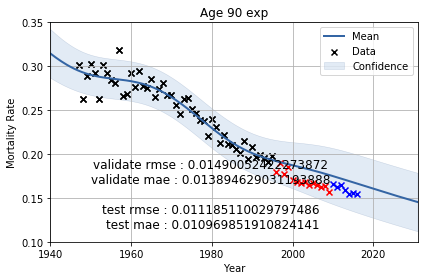

array([ 1.31871584e+07, -9.02192260e-03])

In [12]:
gp_regression(x_train, y_train, exp, (1, -0.00001),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

params:[0.03317154]


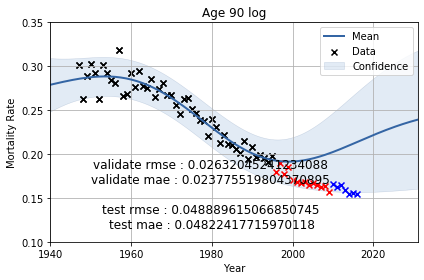

array([0.03317154])

In [13]:
gp_regression(x_train, y_train, log, (0.0001),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

params:[ 2.03332468e-06 -1.20630359e-02  2.38519882e+01 -1.57182438e+04]


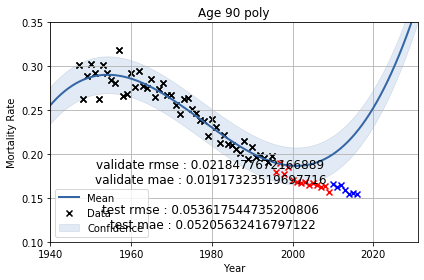

array([ 2.03332468e-06, -1.20630359e-02,  2.38519882e+01, -1.57182438e+04])

In [14]:
gp_regression(x_train, y_train, poly, (0.1, 0.1, 0.1, 0.001),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

params:[-2.33827617e-03  4.86042211e+00]


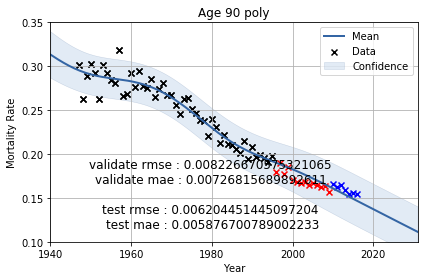

array([-2.33827617e-03,  4.86042211e+00])

In [15]:
gp_regression(x_train, y_train, poly, (0.001, 0.001,),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

  0%|          | 0/1296 [00:00<?, ?it/s]

[('sa', 1), ('sa', 2), ('sal', 1), ('sal', 2), ('box_cox', 1), ('box_cox', 2)]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
params:[-9.23416996e-02  1.81848289e+02]


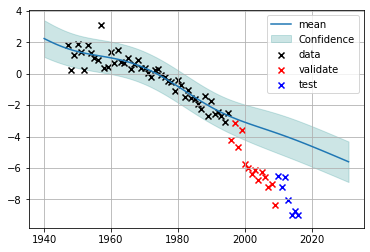

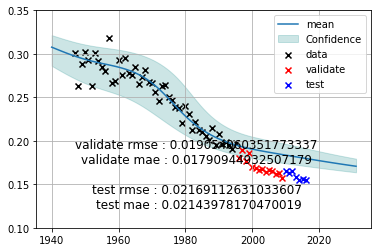

  0%|          | 1/1296 [00:00<21:00,  1.03it/s]

validate rmse : 0.019054060351773337 
 validate mae : 0.01790944932507179 

    test rmse : 0.02169112631033607 
 test mae : 0.02143978170470019
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 2))
params:[-9.23416264e-02  1.81848146e+02]


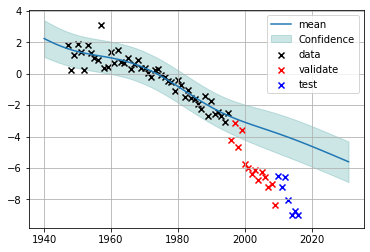

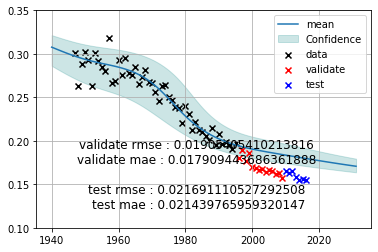

  0%|          | 2/1296 [00:01<19:07,  1.13it/s]

validate rmse : 0.01905405410213816 
 validate mae : 0.017909443686361888 

    test rmse : 0.021691110527292508 
 test mae : 0.021439765959320147
(('sa', 1), ('sa', 1), ('sa', 1), ('sal', 1))
params:[-1.18236682e-01  2.32984301e+02]


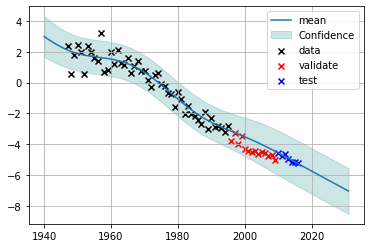

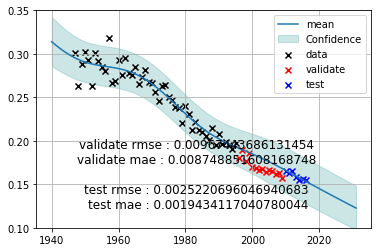

  0%|          | 3/1296 [00:04<38:02,  1.77s/it]

validate rmse : 0.00967443686131454 
 validate mae : 0.008748851608168748 

    test rmse : 0.0025220696046940683 
 test mae : 0.0019434117040780044
(('sa', 1), ('sa', 1), ('sa', 1), ('sal', 2))
params:[-5.06462180e+02  1.00327275e+06]


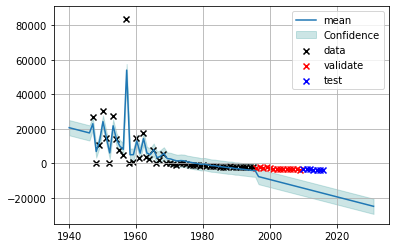

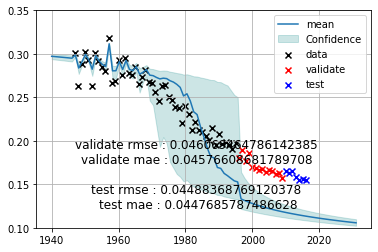

  0%|          | 4/1296 [00:09<1:05:12,  3.03s/it]

validate rmse : 0.046069464786142385 
 validate mae : 0.04576608681789708 

    test rmse : 0.04488368769120378 
 test mae : 0.0447685787486628
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
params:[-9.51593456e-02  1.86341469e+02]


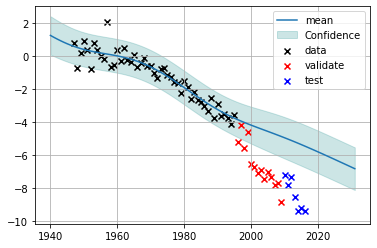

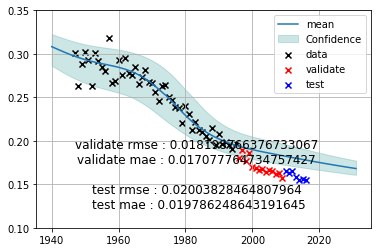

  0%|          | 5/1296 [00:10<47:13,  2.19s/it]  

validate rmse : 0.018198766376733067 
 validate mae : 0.017077764734757427 

    test rmse : 0.02003828464807964 
 test mae : 0.019786248643191645
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 2))
params:[-9.15346068e-02  1.78094149e+02]


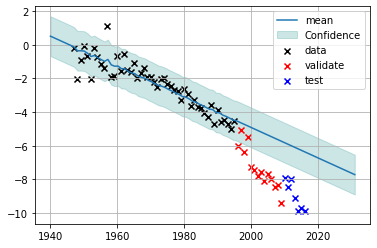

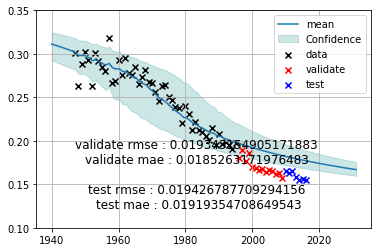

  0%|          | 6/1296 [00:11<36:44,  1.71s/it]

validate rmse : 0.019343154905171883 
 validate mae : 0.0185263171976483 

    test rmse : 0.019426787709294156 
 test mae : 0.01919354708649543
(('sa', 1), ('sa', 1), ('sa', 2), ('sa', 1))
params:[-9.23417977e-02  1.81848483e+02]


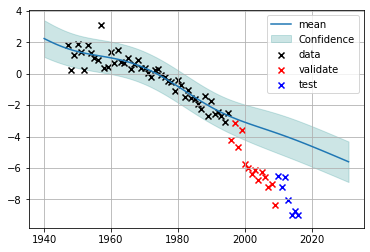

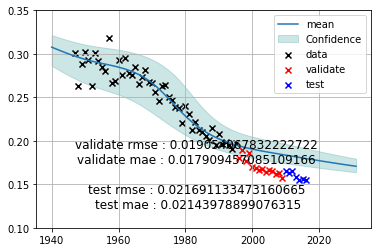

  1%|          | 7/1296 [00:12<31:26,  1.46s/it]

validate rmse : 0.019054067832222722 
 validate mae : 0.017909457085109166 

    test rmse : 0.021691133473160665 
 test mae : 0.02143978899076315
(('sa', 1), ('sa', 1), ('sa', 2), ('sa', 2))
params:[-9.23416818e-02  1.81848254e+02]


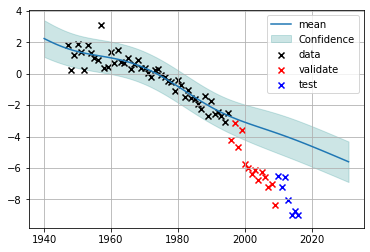

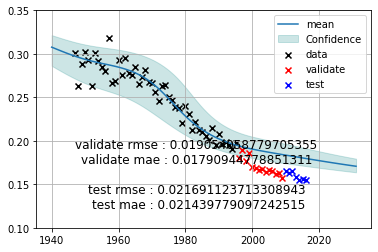

  1%|          | 8/1296 [00:12<28:00,  1.30s/it]

validate rmse : 0.019054058779705355 
 validate mae : 0.01790944778851311 

    test rmse : 0.021691123713308943 
 test mae : 0.021439779097242515
(('sa', 1), ('sa', 1), ('sa', 2), ('sal', 1))
params:[-1.18211371e-01  2.32935433e+02]


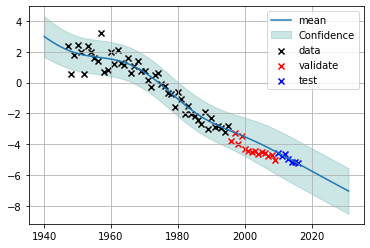

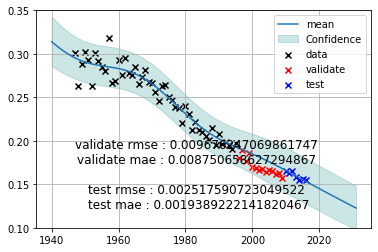

  1%|          | 9/1296 [00:15<32:59,  1.54s/it]

validate rmse : 0.009676247069861747 
 validate mae : 0.008750658627294867 

    test rmse : 0.002517590723049522 
 test mae : 0.0019389222141820467
(('sa', 1), ('sa', 1), ('sa', 2), ('sal', 2))
params:[-1.14377703e-01  2.25213004e+02]


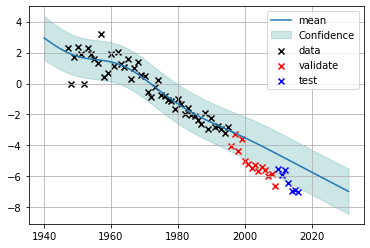

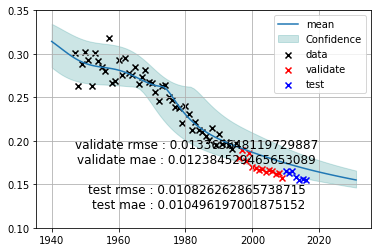

  1%|          | 10/1296 [00:20<1:00:06,  2.80s/it]

validate rmse : 0.013365648119729887 
 validate mae : 0.012384529465653089 

    test rmse : 0.010826262865738715 
 test mae : 0.010496197001875152
(('sa', 1), ('sa', 1), ('sa', 2), ('box_cox', 1))
params:[-9.51593089e-02  1.86341397e+02]


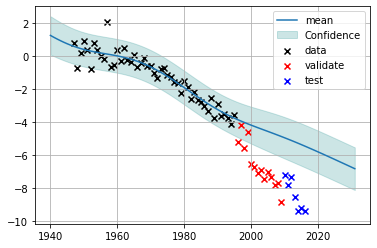

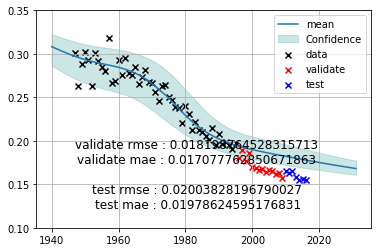

  1%|          | 11/1296 [00:21<47:43,  2.23s/it]  

validate rmse : 0.018198764528315713 
 validate mae : 0.017077762850671863 

    test rmse : 0.02003828196790027 
 test mae : 0.01978624595176831
(('sa', 1), ('sa', 1), ('sa', 2), ('box_cox', 2))
params:[-9.15346015e-02  1.78094138e+02]


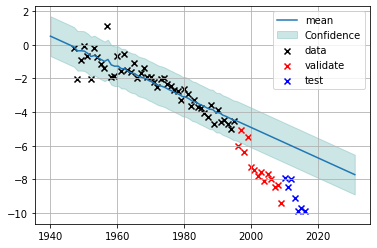

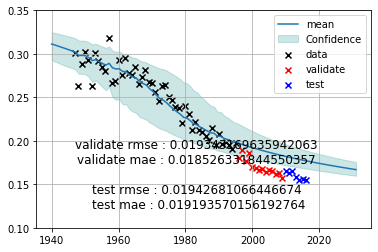

  1%|          | 12/1296 [00:22<38:54,  1.82s/it]

validate rmse : 0.019343169635942063 
 validate mae : 0.018526331844550357 

    test rmse : 0.01942681066446674 
 test mae : 0.019193570156192764
(('sa', 1), ('sa', 1), ('sal', 1), ('sa', 1))


In [ ]:
result = grid_search(cwgp_regression, x_train, y_train, {"c":4,"n":[1,2],"transformations":["sa","sal","box_cox"]},
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
                    )